# Parse transitions along DTA trees

August 15, 2019 

To properly deal with the uncertainty of the number of transitions into Washington, I am going to go through the posterior distribution of trees in the .trees output file from running DTA in beast. I will use the counts of the number of transitions to generate a distribution over the number of transitions. 

In [1]:
import sys, subprocess, glob, os, shutil, re, importlib
from subprocess import call
import imp
bt = imp.load_source('baltic', '../../baltic/baltic/baltic.py')

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import pandas as pd
import textwrap as textwrap
from textwrap import wrap
import pymc3
import rpy2
import numpy as np
from scipy.special import binom

%load_ext rpy2.ipython

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
mpl.rcParams['font.serif'] = "Helvetica"
typeface='Helvetica'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=16

In [3]:
def get_taxa_lines(tree_path):    
    
    # write out a temp tree file
    temp_tree = tree_path.replace(".trees",".temp.tree")
    with open(temp_tree, "w") as outfile: 
        outfile.write("")

    lines_to_write = ""
    with open(tree_path, 'rU') as infile:
        for line in infile: ## iterate through each line
            if 'state' not in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                lines_to_write = lines_to_write + line

    return(lines_to_write)

In [4]:
def get_burnin_value(tree_path, burnin_percent):
    with open(tree_path, 'rU') as infile:
        numtrees = 0
        for line in infile: ## iterate through each line
            if 'state' in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                numtrees += 1
    
    burnin = numtrees * burnin_percent
    return(burnin)

In [5]:
def retrieve_subtrees(tree):
    
    traitName='geo'

    tree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    tree_strings={division:[] for division in division_order}
    subtype_trees={division:[] for division in division_order}

    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k

        ## get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName]      # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:       # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName]              # kploc = trait of parental node
        else:
            kploc='ancestor'

        ## if states do not match
        if kloc!=kploc:      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName]==kloc     # traverse tree for all nodes whose traitname = kc
            #print('subtree resulting from %s>%s switch, traversing within %s')%(kploc,kloc,kloc)

            subtree=tree.subtree(k,traverse_condition=traverse_condition) #traitName = traitName ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()
                subtype_trees[kloc].append((kploc,subtree))
    
    return(subtype_trees)

In [6]:
def count_transitions(tree_path,temp_tree):
    
    ## count transitions in the posterior set of trees 
    trees_per_file={}
    transitions_dict = {}
    treeCounter = 0

    # open .trees file and read in line by line
    with open(tree_path, 'rU') as infile:
        for line in infile: ## iterate through each line

            # write an empty tree to read file; this will get filled in as a new nexus file for each tree in the posterior
            with open(temp_tree, "w") as outfile:
                outfile.write("")

            # if tree line...
            if 'tree STATE_' in line:
                treeCounter += 1
                identifier = " ".join(line.split(" ")[0:2])

                if treeCounter > burnin:

                    with open(temp_tree, "a") as outfile:
                        outfile.write(lines_to_write)
                        outfile.write(line)
                    tree = bt.loadNexus(temp_tree)

                    # run this function to retrieve all of the transitions into Washington (i.e., all the Washington subtrees)
                    subtype_trees = retrieve_subtrees(tree)

                    # output the number of washington subtrees to dictionary
                    transitions_dict[identifier] = len(subtype_trees['washington'])

                    with open(dict_outfile, "a") as outfile: 
                        outfile.write(identifier + "\t" + str(len(subtype_trees['washington'])) + "\n")

In [7]:
division_order = ["california","new_york","massachusetts","virginia","georgia","manitoba","arkansas","north_dakota",
          "louisiana","ontario","texas","indiana","michigan","montana","new_hampshire","ohio",
          "washington","illinois","kansas","pennsylvania","new_jersey","british_columbia","iowa","missouri",
                 "north_carolina","alabama","wisconsin"]

In [3]:
# specify tree path
tree_path = "/Users/lmoncla/Documents/Mumps/beast/DTA/2020-10-23-skygrid-25-exp-bssvs-prior/mumps-north-american-seqs-DTA-2020-01-16.aligned.no-metadata.trees"
#tree_path = "/Users/lmoncla/Documents/Mumps/beast/DTA/2020-10-23-skygrid-25-exp-bssvs-prior/offset-26/mumps-north-american-seqs-DTA-2020-01-16.aligned.no-metadata.trees"

# specify burnin percentage
dict_outfile = tree_path.replace(".trees",".transitions.txt")
temp_tree = tree_path.replace(".trees",".temp.tree")
burnin_percent = 0.10

In [9]:
with open(dict_outfile, "w") as outfile:
    outfile.write("state\tnumber_transitions\n")

In [10]:
# get taxa line and burnin number
lines_to_write = get_taxa_lines(tree_path)
burnin = get_burnin_value(tree_path, burnin_percent)
print(burnin)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 'U' mode is deprecated
  if __name__ == '__main__':
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 'U' mode is deprecated
  


1000.1


In [11]:
count_transitions(tree_path,temp_tree)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 'U' mode is deprecated
  if __name__ == '__main__':


In [12]:
df = pd.DataFrame.from_csv(tree_path.replace(".trees",".transitions.txt"), sep="\t")
df.reset_index(inplace=True)
df.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


,state,number_transitions
0,tree STATE_10000000,14
1,tree STATE_10010000,12
2,tree STATE_10020000,14
3,tree STATE_10030000,14
4,tree STATE_10040000,13


In [15]:
df['number_transitions'].mean()

13.507054771692035

# Read back in the output file to dataframe and plot

In [4]:
skygrid = pd.DataFrame.from_csv("../beast/output/no-metadata/mumps-north-american-seqs-DTA-2020-12-10-exp-mean-26.transitions.txt", sep="\t")
skygrid.reset_index(inplace=True)
skygrid.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


,state,number_transitions
0,tree STATE_10000000,14
1,tree STATE_10010000,12
2,tree STATE_10020000,14
3,tree STATE_10030000,14
4,tree STATE_10040000,13


In [5]:
skygrid['number_transitions'].mean()

13.327074769470059

In [6]:
skygrid['number_transitions'].mode()

0    13
dtype: int64

In [7]:
x = skygrid['number_transitions']
hpd = pymc3.stats.hpd(x)
hpd

array([12, 15])

In [8]:
skygrid.head()

,state,number_transitions
0,tree STATE_10000000,14
1,tree STATE_10010000,12
2,tree STATE_10020000,14
3,tree STATE_10030000,14
4,tree STATE_10040000,13


In [18]:
min_value = min(skygrid['number_transitions'])
max_value = max(skygrid['number_transitions'])
print(min_value, max_value)

In [44]:
df = pd.DataFrame(skygrid["number_transitions"].value_counts())
df.reset_index(inplace=True)
df.columns = ['number_transitions','number_trees']
df['proportion_trees'] = (df['number_trees'])/(sum(df['number_trees']))
df

,number_transitions,number_trees,proportion_trees
0,13,4193,0.465837
1,14,2238,0.248639
2,12,1247,0.138540
3,15,822,0.091323
4,11,225,0.024997
5,16,199,0.022109
6,17,48,0.005333
7,10,21,0.002333
8,18,6,0.000667
9,20,1,0.000111


In [46]:
# finally, add in a count of 0 for any transition value that is not observed 
for i in range(min_value, max_value+1):
    x = df[df['number_transitions'] == i]
    if len(x) == 0:
        new_row = pd.DataFrame.from_dict({'number_transitions':[i],"number_trees":0,"proportion_trees":0})
        df = df.append(new_row)
    
df

,number_transitions,number_trees,proportion_trees
0,13,4193,0.465837
1,14,2238,0.248639
2,12,1247,0.138540
3,15,822,0.091323
4,11,225,0.024997
5,16,199,0.022109
6,17,48,0.005333
7,10,21,0.002333
8,18,6,0.000667
9,20,1,0.000111


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

  warnings.warn(x, RRuntimeWarning)


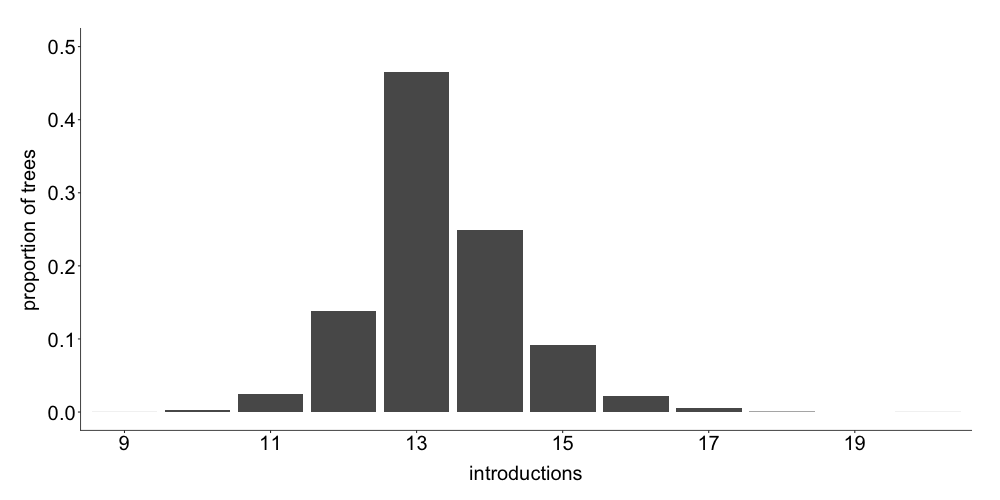

In [50]:
%%R -w 1000 -h 500 -u px -i df,min_value,max_value  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

array_of_transitions <- as.character(min_value:max_value)

df$number_transitions = as.character(df$number_transitions)
df$number_transitions = factor(df$number_transitions, levels=array_of_transitions)

p <- ggplot(data=df, aes(x=number_transitions, y=proportion_trees)) + 
    geom_col()+  #aes(y = (..count..)/sum(..count..))
    labs(x="introductions",y="proportion of trees")+
    #ggtitle("Re estimates") + 
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_x_discrete(breaks=array_of_transitions)+
    scale_x_discrete(breaks=c("9","","11","","13","","15","","17","","19",""))+
    scale_y_continuous(limits=c(0,0.5), breaks=seq(0,0.5,0.1))+
    #scale_color_manual(values=c("#4784C7", "#E39B39"))+
    #scale_fill_manual(values=c("#4784C7", "#E39B39"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=16))+
    theme(axis.title.y=element_text(size=20, vjust=4))+
    theme(axis.title.x=element_text(size=20, vjust=-3))+
    theme(axis.text=element_text(size=20, colour="black"))+
    theme(axis.text.x=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("2020-12-14-DTA-skygrid-25-WA-introductions.pdf", p, width = 5, height = 3.5, path="/Users/lmoncla/Documents/Mumps/paper-and-figure-drafts/individual-PDFs/")
p